In [3]:
from scipy import stats
import numpy as np
import math


In [4]:
def black_scholes(s, k, t, v, rf, cp):
    """Price an option using the Black-Scholes model.
    
    s : initial stock price
    k : strike price
    t : expiration time
    v : volatility
    rf : risk-free rate
    cp : +1/-1 for call/put
    """
    d1 = (math.log(s/k)+(rf+0.5*math.pow(v,2))*t)/(v*math.sqrt(t))
    d2 = d1 - v*math.sqrt(t)
    optprice = cp*s*stats.norm.cdf(cp*d1) - \
        cp*k*math.exp(-rf*t)*stats.norm.cdf(cp*d2) 
    return optprice


In [5]:
def jarrow_rudd(s, k, t, v, rf, cp, am=False, n=100):
    """Price an option using the Jarrow-Rudd binomial model.
    
    s : initial stock price
    k : strike price
    t : expiration time
    v : volatility
    rf : risk-free rate
    cp : +1/-1 for call/put
    am : True/False for American/European
    n : binomial steps
    """
    #Basic calculations
    h = t/n
    mu=(rf-0.5*math.pow(v,2))
    u = math.exp(mu*h+v*math.sqrt(h))
    d = math.exp(mu*h-v*math.sqrt(h))
    drift = math.exp(rf*h)
    q = (drift-d)/(u-d)

    #Process the terminal stock price
    stkval = np.zeros((n+1,n+1))
    optval = np.zeros((n+1,n+1))
    stkval[0,0] = s
    for i in range(n+1):
        for j in range(i + 1):
            stkval[i, j] = s * u**(i-j) * d**j

    #Backward recursion for option price
    for j in range(n+1):
        optval[n,j] = max(0,cp*(stkval[n,j]-k))
    for i in range(n-1,-1,-1):
        for j in range(i+1):
            optval[i,j] = (q*optval[i+1,j]+(1-q)*optval[i+1,j+1])/drift
            if am:
                optval[i,j] = max(optval[i,j],cp*(stkval[i,j]-k))

    return optval[0,0],stkval


In [6]:
def cox_ross_rubinstein(s, k, t, v, rf, cp, am=False, n=100):
    """Price an option using the Jarrow-Rudd binomial model.
    
    s : initial stock price
    k : strike price
    t : expiration time
    v : volatility
    rf : risk-free rate
    cp : +1/-1 for call/put
    am : True/False for American/European
    n : binomial steps
    """
    #Basic calculations
    h = t/n
    u = math.exp(v*math.sqrt(h))
    d = math.exp(-v*math.sqrt(h))
    drift = math.exp(rf*h)
    q = (drift-d)/(u-d)

    #Process the terminal stock price
    stkval = np.zeros((n+1,n+1))
    optval = np.zeros((n+1,n+1))
    stkval[0,0] = s
    for i in range(1,n+1):
        stkval[i,0] = stkval[i-1,0]*u
        for j in range(1,i+1):
            stkval[i,j] = stkval[i-1,j-1]*d

    #Backward recursion for option price
    for j in range(n+1):
        optval[n,j] = max(0,cp*(stkval[n,j]-k))
    for i in range(n-1,-1,-1):
        for j in range(i+1):
            optval[i,j] = (q*optval[i+1,j]+(1-q)*optval[i+1,j+1])/drift
            if am:
                optval[i,j] = max(optval[i,j],cp*(stkval[i,j]-k))

    return optval[0,0],stkval


In [7]:
def modified_cox_ross_rubinstein(s, k, t, v, rf, cp, am=False, n=100):
    """Price an option using the Jarrow-Rudd binomial model.
    
    s : initial stock price
    k : strike price
    t : expiration time
    v : volatility
    rf : risk-free rate
    cp : +1/-1 for call/put
    am : True/False for American/European
    n : binomial steps
    """
    #Basic calculations
    h = t/n
    mu=(rf-0.5*math.pow(v,2))
    drift = math.exp(rf*h)
    u = (math.exp(-rf * h) / 2) * (mu + math.exp((2 * rf + v**2) * h) + math.sqrt( (1 + math.exp((2 * rf + v**2) * h))**2 - 4 * math.exp(2 * rf * h)))
    d = (math.exp(-rf * h) / 2) * (mu + math.exp((2 * rf + v**2) * h) - math.sqrt( (1 + math.exp((2 * rf + v**2) * h))**2 - 4 * math.exp(2 * rf * h)))
    q = (drift-d)/(u-d)
    
    #Process the terminal stock price
    stkval = np.zeros((n+1,n+1))
    optval = np.zeros((n+1,n+1))
    stkval[0,0] = s
    for i in range(1,n+1):
        stkval[i,0] = stkval[i-1,0]*u
        for j in range(1,i+1):
            stkval[i,j] = stkval[i-1,j-1]*d

    #Backward recursion for option price
    for j in range(n+1):
        optval[n,j] = max(0,cp*(stkval[n,j]-k))
    for i in range(n-1,-1,-1):
        for j in range(i+1):
            optval[i,j] = (q*optval[i+1,j]+(1-q)*optval[i+1,j+1])/drift
            if am:
                optval[i,j] = max(optval[i,j],cp*(stkval[i,j]-k))

    return optval[0,0],stkval


In [8]:
def kamrad_ritchken(s, k, t, v, rf, cp, am=False, n=100):
    """Price an option using the kamrad-ritchken binomial model.
    
    s : initial stock price
    k : strike price
    t : expiration time
    v : volatility
    rf : risk-free rate
    cp : +1/-1 for call/put
    am : True/False for American/European
    n : trinomial steps
    """
    #Basic calculations
    h = t/n
    mu=rf-v**2/2
    Lambda= math.sqrt(1/(1-1/3))
    alpha= math.sqrt(1+h*(mu/v)**2)
    u = np.exp(v*alpha*Lambda * np.sqrt(h))
    d = 1.0 / u
    drift = math.exp(rf*h)
    pu=1/(2*Lambda**2)+mu*np.sqrt(h)/(2*Lambda*v)
    pd=1/(2*Lambda**2)-mu*np.sqrt(h)/(2*Lambda*v)
    pm=1-1/Lambda**2

    #Process the terminal stock price
    stkval = np.zeros((n+1,2*n+1))
    optval = np.zeros((n+1,2*n+1))
    stkval[0,0] = s
    for i in range(n+1):
        for j in range(2*i + 1):
            stkval[i, j] = s * u**(i-j if (i>=j) else 0) * d**((j-i) if (i<j) else 0)

    #Backward recursion for option price
    for j in range(n+1):
        optval[n,j] = max(0,cp*(stkval[n,j]-k))
    for i in range(n-1,-1,-1):
        for j in range(2*i+1):
            optval[i,j] = (pu*optval[i+1,j]+pm*optval[i+1,j+1]+pd*optval[i+1,j+2]) /drift
            if am:
                optval[i,j] = max(optval[i,j],cp*(stkval[i,j]-k))

    return optval[0,0],stkval


In [12]:
# Define parameters
s=S = 100
K = 110
T = 0.5
rf = 0.03
sigma = 0.3
n=2

In [13]:
u=1.001
d=1/u

In [14]:
stkval = np.zeros((n+1,2*n+1))
optval = np.zeros((n+1,2*n+1))
stkval[0,0] = s
for i in range(n+1):
    for j in range(2*i + 1):
        stkval[i, j] = s * u**(i-j if (i>=j) else 0) * d**((j-i) if (i<j) else 0)
stkval

array([[100.       ,   0.       ,   0.       ,   0.       ,   0.       ],
       [100.1      , 100.       ,  99.9000999,   0.       ,   0.       ],
       [100.2001   , 100.1      , 100.       ,  99.9000999,  99.8002996]])

In [15]:
stkval = np.zeros((n+1,2*n+1))
optval = np.zeros((n+1,2*n+1))
stkval[0,0] = s
for i in range(n+1):
    for j in range(2*i + 1):
        stkval[i, j] = s * d**(i-j if (i>=j) else 0) * u**((j-i) if (i<j) else 0)
stkval

array([[100.       ,   0.       ,   0.       ,   0.       ,   0.       ],
       [ 99.9000999, 100.       , 100.1      ,   0.       ,   0.       ],
       [ 99.8002996,  99.9000999, 100.       , 100.1      , 100.2001   ]])

In [251]:
black_scholes(S, K, T,sigma,rf, 1)

5.239505678484882

In [252]:
cox_ross_rubinstein(S, K, T,sigma,rf, 1, n=10)[0]

5.363408688114021

In [254]:
modified_cox_ross_rubinstein(S, K, T,sigma,rf, 1, n=10)[0]

0.0

In [221]:
import option_models

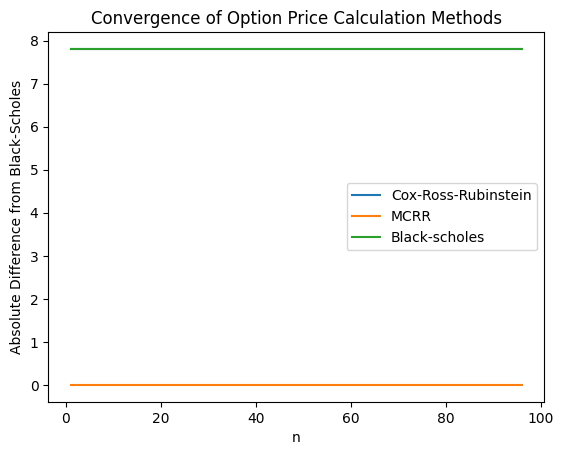

In [238]:
import matplotlib.pyplot as plt
import numpy as np


n_values = np.arange(1, 100, 5)  # Vary 'n' from 1 to 100 with step 5

# Calculate option prices using different methods for each 'n'
cox_ross_rubinstein_prices = [cox_ross_rubinstein(S, K, T,sigma,rf, 1, am=False, n=n)[0] for n in n_values]
modified_cox_ross_rubinstein_p = [modified_cox_ross_rubinstein(S, K, T,sigma,rf, 1, n=n)[0] for n in n_values]
black_scholes_price = [black_scholes(S, K, T,sigma,rf, 1)]*20

# Plot the convergence graph
plt.plot(n_values, cox_ross_rubinstein_prices, label='Cox-Ross-Rubinstein')
plt.plot(n_values, modified_cox_ross_rubinstein_p, label='MCRR')
plt.plot(n_values, black_scholes_price, label='Black-scholes')
plt.xlabel('n')
plt.ylabel('Absolute Difference from Black-Scholes')
plt.title('Convergence of Option Price Calculation Methods')
plt.legend()
plt.show()


In [211]:
kamrad_ritchken(S, K, T,sigma,rf, 1, am=False, n=1900)[0]

7.808845120133544

In [212]:
black_scholes(S, K, T,sigma,rf, 1)

7.807674312891706

# expand


In [214]:
import math
import numpy as np



In [215]:
def kamrad_ritchken_varying_volatility(s, k, t, v_func, rf, cp, am=False, n=100):
    """Price an option using the kamrad-ritchken binomial model with varying volatility.
    
    s : initial stock price
    k : strike price
    t : expiration time
    v_func : function that takes time 't' and returns volatility at time 't'
    rf : risk-free rate
    cp : +1/-1 for call/put
    am : True/False for American/European
    n : trinomial steps
    """
    # Basic calculations
    h = t / n
    mu = rf - v_func(t)**2 / 2
    Lambda = math.sqrt(1 / (1 - 1/3))
    alpha = math.sqrt(1 + h * (mu / v_func(t))**2)
    u = np.exp(v_func(t) * alpha * Lambda * np.sqrt(h))
    d = 1.0 / u
    drift = math.exp(rf * h)
    pu = 1 / (2 * Lambda**2) + mu * np.sqrt(h) / (2 * Lambda * v_func(t))
    pd = 1 / (2 * Lambda**2) - mu * np.sqrt(h) / (2 * Lambda * v_func(t))
    pm = 1 - 1 / Lambda**2

    # Process the terminal stock price
    stkval = np.zeros((n+1, 2*n+1))
    optval = np.zeros((n+1, 2*n+1))
    stkval[0, 0] = s
    for i in range(n+1):
        for j in range(2*i + 1):
            stkval[i, j] = s * u**(i-j if (i >= j) else 0) * d**((j-i) if (i < j) else 0)

    # Backward recursion for option price
    for j in range(n+1):
        optval[n, j] = max(0, cp * (stkval[n, j] - k))

    for i in range(n-1, -1, -1):
        for j in range(2*i+1):
            optval[i, j] = (pu * optval[i+1, j] + pm * optval[i+1, j+1] + pd * optval[i+1, j+2]) / drift
            if am:
                optval[i, j] = max(optval[i, j], cp * (stkval[i, j] - k))

    return optval[0, 0], stkval


In [216]:
def constant_volatility(t):
    return 0.2  # Constant volatility of 20%

def varying_volatility(t):
    return 0.2 + 0.02 * t  # Linearly increasing volatility


In [217]:
import numpy as np
from scipy.stats import norm

# Define a range of input values
S_values = np.linspace(90, 110, 21)  # Initial stock price
K_values = np.linspace(90, 110, 21)  # Strike price
T_values = np.linspace(0.25, 2, 5)  # Time to expiration
v_values = np.linspace(0.1, 0.3, 5)  # Volatility
r_values = np.linspace(0.01, 0.05, 5)  # Risk-free rate

# Loop through all combinations of input values
for S in S_values:
    for K in K_values:
        for T in T_values:
            for sigma in v_values:
                for rf in r_values:
                    # Calculate option price using Black-Scholes
                    d1 = (np.log(S/K) + (rf + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
                    d2 = d1 - sigma*np.sqrt(T)
                    BS_price = (norm.cdf(d1)*S - norm.cdf(d2)*K) * np.exp(-rf*T)
                    
                    # Calculate option price using Kamrad-Ritchken model
                    def constant_volatility(t):
                        return sigma  # Assuming constant volatility
                    KR_price, _ = kamrad_ritchken_varying_volatility(S, K, T, constant_volatility, rf, 1, False, 100)
                    
                    # Compare the prices and perform further analysis as needed
                    price_difference = abs(BS_price - KR_price)
                    # Perform any additional analysis or record the results as needed


In [219]:
BS_price

16.26965060928291

In [220]:
KR_price

23.2986027489125

In [218]:
price_difference

7.028952139629592